In [1]:
import pandas as pd 
import seaborn as sns
import numpy as np 
import pymc3 as pm 
import theano
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../data/Covid-19 SG Clean.csv')
data['Date'] = pd.to_datetime(data['Date'], format="%d/%m/%Y")
data = data.sort_values('Date')

In [3]:
new_cases = data['Daily Confirmed '].values
len_observed = len(new_cases)

In [4]:
start_id = 50

local_cases = data['Daily Local transmission'].values[start_id:]
imported_cases = data['Daily Imported'].values[start_id:]
len_observed = len(local_cases)
print(len_observed)

448


In [81]:
NPIS_proc = pd.read_csv('data/NPIS_LC_processed.csv')
NPIS_wanted = NPIS_proc.iloc[start_id:, 1::]

In [82]:
npi_series = data['Phase'].iloc[start_id:]
values_in_npi = npi_series.unique()

def check_nan(vals):
    for v in vals:
        if pd.isna(v):
            return True
    return False

if check_nan(values_in_npi):
    # NaN should be the base grou
    converted_npi =  pd.get_dummies(npi_series)
    print("None set as base class")

else:
    converted_npi = pd.get_dummies(npi_series)
    remove_var = converted_npi.columns[0]
    converted_npi = converted_npi.iloc[:,1:]
    print(remove_var + " set as base class")

None set as base class


Generic Loader Script

In [83]:
import os 
os.listdir('../Results')

['SM_Trace_Start_115_prediction_ahead_2_1500_3500',
 'SM_Trace_Start_115_prediction_ahead_2_1500_3500_analysis',
 'SM_Trace_Start_122_prediction_ahead_2_1500_3500',
 'SM_Trace_Start_122_prediction_ahead_2_1500_3500_analysis',
 'SM_Trace_Start_129_prediction_ahead_2_1500_3500',
 'SM_Trace_Start_129_prediction_ahead_2_1500_3500_analysis',
 'SM_Trace_Start_136_prediction_ahead_2_1500_3500',
 'SM_Trace_Start_136_prediction_ahead_2_1500_3500_analysis',
 'SM_Trace_Start_143_prediction_ahead_2_1500_3500',
 'SM_Trace_Start_143_prediction_ahead_2_1500_3500_analysis',
 'SM_Trace_Start_150_prediction_ahead_2_1500_3500',
 'SM_Trace_Start_150_prediction_ahead_2_1500_3500_analysis',
 'SM_Trace_Start_410_prediction_ahead_2_1500_4000',
 'SM_Trace_Start_410_prediction_ahead_2_1500_4000_analysis',
 'SM_Trace_Start_417_prediction_ahead_2_1500_3500',
 'SM_Trace_Start_417_prediction_ahead_2_1500_3500_analysis',
 'SM_Trace_Start_424_prediction_ahead_2_1500_3500',
 'SM_Trace_Start_431_prediction_ahead_2_1500

In [196]:
end_date_list = [410, 417, 424, 431, 438]

end_date = 438
prediction_t = 7

n_chains = 2
tune_steps = 1500
train_steps = 4000

load_fp = f"../Results/SM_Trace_Start_{end_date}_prediction_ahead_{n_chains}_{tune_steps}_{train_steps}"


In [197]:
print("Length import Cases: ",len(imported_cases))
print("Length local Cases: ", len(local_cases))

prediction_t = prediction_t # Days
end_date = end_date

train_local_cases = local_cases[0:end_date]
train_imported_cases = imported_cases[0:end_date]

actual = local_cases[end_date:end_date+prediction_t]

train_pad = [np.nan for x in range(prediction_t)]
imported_pad = [train_imported_cases[-1] for x in range(prediction_t)]

model_input = pd.Series(np.concatenate([train_local_cases, train_pad]))
imported_input = np.concatenate([train_imported_cases, imported_pad])

print("Length training cases: ", len(train_local_cases))
print("Length into model: ", len(model_input)," ",len(imported_input))

len_observed = len(model_input)

Length import Cases:  448
Length local Cases:  448
Length training cases:  438
Length into model:  445   445


In [198]:
end_date

438

In [199]:
from sm_data import generate_prediction_data_v1, generate_NPI_prediction_data, generate_NPI_prediction_data_v1
from covid.patients import get_delay_distribution, get_delays_from_patient_data, download_patient_data
from sm_utils import *
from sm_utils import _get_convolution_ready_gt

save_fp = f"../Results/SM_Trace_Start_{end_date}_prediction_ahead_{n_chains}_{tune_steps}_{train_steps}"

print("End Date: ", end_date)
print("Prediction_t: ", prediction_t)

print('\n')
print("TRAINING CONFIG: ")
print("No Chains: ", n_chains)
print("No Tuning: ", tune_steps)
print("No MCMC Steps: ", train_steps)

print('\n')
print("FP: ", save_fp)

DATA_PATH = '../data/Covid-19 SG Clean.csv'
NPI_PATH = 'data/NPIS_LC_processed.csv'
start_id = 50
#end_date = 115
#prediction_t = 7

model_input, imported_input, len_observed = generate_prediction_data_v1(DATA_PATH, start_id,
                             end_date=end_date, prediction_t=prediction_t, imported_case_extra='ma')

NPIS_array = generate_NPI_prediction_data_v1(NPI_PATH, start_id, end_date, prediction_t)
#NPIS_array = NPIS_array[:,1:].astype('float')
num_NPIS = NPIS_array.shape[1]

# Get serial interval and delay dist
convolution_ready_gt = _get_convolution_ready_gt(len_observed)
p_delay = get_p_delay()
likelihood_fun = 'PO' # PO or ZINB

with pm.Model() as model_11:
    print("Starting Training")
    # r0 positive
    log_r_t = pm.GaussianRandomWalk(
        'log_r_t',
        sigma=0.035,
        shape=len_observed)
    
    beta_list = []
    for i in range(num_NPIS):
        beta_list.append(pm.Normal(f"b_{i}", 0, sigma=0.03))
    betas = pm.math.stack(beta_list, 0)
    #beta_intercept = pm.Normal('b_inter', 0, sigma=0.1)
    rt_covariates = pm.math.dot(np.array(NPIS_array), betas)
    
    
    # Form r_t as GRW + covariates
    r_t = pm.Deterministic('r_t', pm.math.exp(log_r_t + rt_covariates))
    
        
    # Imported cases leak percent
    log_eps_t = pm.GaussianRandomWalk(
        'log_eps_t',
        sigma=0.035,
        shape=len_observed)
    #eps_t = pm.Deterministic('eps_t', pm.math.exp(log_eps_t))
    eps_t = pm.Beta('eps_t', alpha=1, beta=1000)
    
    # Seed pop
    seed = pm.Exponential('Seed', 150)  # Scale of infection will be small
    y0 = tt.zeros(len_observed)
    y0 = tt.set_subtensor(y0[0], seed)
    # Apply recursively to populate tensor
    outputs, _ = theano.scan(
            fn=lambda t, gt , i_cases, y, r_t: tt.set_subtensor(y[t], tt.sum(r_t*y*gt) + eps_t * i_cases),
            sequences=[tt.arange(1, len_observed), convolution_ready_gt, theano.shared(imported_input)],
            outputs_info=y0,
            non_sequences=r_t,
            n_steps=len_observed-1,
    )
    
    infections = pm.Deterministic('infections', outputs[-1])
    
    
    
    # Test observation
    t_p_delay = pm.Data("p_delay", p_delay)
    
    test_adjusted_positive = pm.Deterministic(
        "test adjusted positive",
        conv(infections, t_p_delay,len(p_delay), len_observed)
    )
    
    # For stability
    test_adjusted_positive_jittered = pm.Deterministic('test_adjusted_positive_jit',
                                                   test_adjusted_positive + 0)
    """
    # Accounts for number of tests 
    # Get number of tests
    tests = pm.Data("tests", tests_performed)
    exposure = pm.Deterministic(
        "exposure",
        pm.math.clip(tests_performed, 1000, 1e9)  # Hard code to 300 test a day for unobs period
    )
    
    positive = pm.Deterministic(
        "positive", exposure * test_adjusted_positive_jittered
    )
    """
    
    # Likelihood
    if likelihood_fun == 'ZINB':
        pm.ZeroInflatedNegativeBinomial('Obs', 
                  mu=test_adjusted_positive_jittered, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  psi = pm.Beta('psi', 2,2),                    
                  observed=model_input)    
        
    elif likelihood_fun == 'NB':
        pm.NegativeBinomial('Obs', 
                  mu=test_adjusted_positive_jittered, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  observed=model_input)
    
    elif likelihood_fun == 'PO':
        print('hi')
        pm.Poisson('Obs', 
                  mu=test_adjusted_positive_jittered,
                  observed=model_input)
    

End Date:  438
Prediction_t:  7


TRAINING CONFIG: 
No Chains:  2
No Tuning:  1500
No MCMC Steps:  4000


FP:  ../Results/SM_Trace_Start_438_prediction_ahead_2_1500_4000
imported cases ma
Length training cases:  438
Length into model:  445   445


/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Starting Training
hi


/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/model.py:1754: ImputationWarning: Data in Obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [200]:
plt_dir = f"../Results/SM_Trace_Start_{end_date}_prediction_ahead_{n_chains}_{tune_steps}_{train_steps}_analysis"
if not os.path.exists(plt_dir):
    os.mkdir(plt_dir)

energy_fp = os.path.join(plt_dir, 'energy.png')
case_fp = os.path.join(plt_dir, 'counts_pred.png')
latent_fp = os.path.join(plt_dir, 'latent_process.png')
rt_fp = os.path.join(plt_dir, 'rt.png')
results_fp = os.path.join(plt_dir, 'pred_results.csv')
beta_fp = os.path.join(plt_dir, 'beta_results.csv')

In [201]:
load_fp

'../Results/SM_Trace_Start_438_prediction_ahead_2_1500_4000'

In [202]:
with model_11:
    trace_11 = pm.load_trace(load_fp) 

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


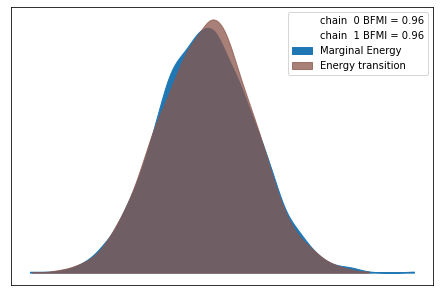

In [203]:
az.plot_energy(trace_11)
plt.savefig(energy_fp)

In [204]:
_, n_traces = trace_11['Obs_missing'].T.shape
temp_dates = np.arange(end_date, end_date+prediction_t).reshape(-1,1)
temp_dates = np.tile(temp_dates,n_traces)

In [205]:
with model_11:
    ppc_11 = pm.sample_posterior_predictive(
        trace_11, random_seed=123)

In [206]:
np.mean(trace_11['Seed'])

0.8274886614751801

In [207]:
ppc_11['Obs'].mean(0).max()

928.831375

In [208]:
ppc_11['Obs'][:,89]

array([299, 331, 301, ..., 305, 347, 323])

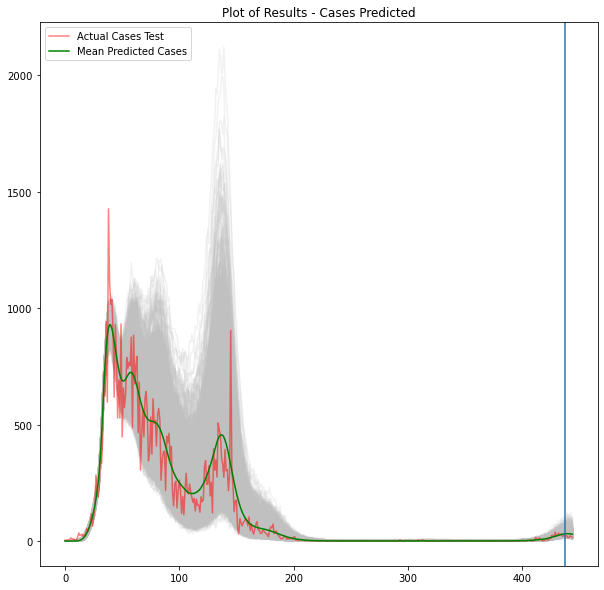

In [209]:
fig, ax = plt.subplots(figsize=(10,10))

#ax.plot(train_local_cases, c='b', label='Local Cases')
#ax.plot(temp_dates, trace_10['Obs_missing'].T, c='silver', alpha=0.2)
ax.plot(ppc_11['Obs'].T, c='silver', alpha=0.2)

ax.plot(np.concatenate([train_local_cases, actual]), c='r', alpha=0.5, label='Actual Cases Test')
ax.plot(ppc_11['Obs'].mean(0), c='g', alpha=1, label='Mean Predicted Cases')
ax.axvline(x=end_date)
ax.set_title("Plot of Results - Cases Predicted")
ax.legend()
plt.show()
fig.savefig(case_fp)

In [210]:
trace_11['test_adjusted_positive_jit'].max()

973.0120761960162

In [211]:
lolz = np.random.poisson(lam=1000, size=1000)

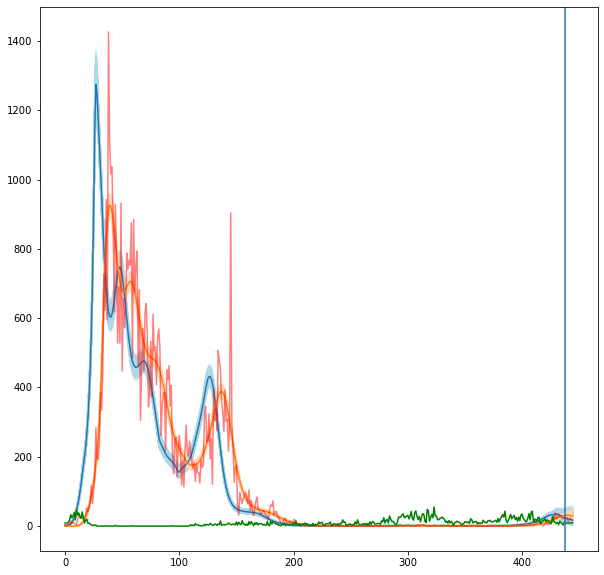

No handles with labels found to put in legend.


In [212]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(trace_11['infections'].T, c='lightblue', alpha=0.1)
ax.plot(trace_11['test_adjusted_positive_jit'].T, c='peachpuff', alpha=0.1)
ax.plot(trace_11['infections'].mean(0))
ax.plot(trace_11['test_adjusted_positive_jit'].mean(0))
ax.plot(np.concatenate([train_local_cases, actual]), c='r', alpha=0.5)
ax.plot(imported_input, c='g')
ax.axvline(x=end_date)
plt.show()
ax.legend()
fig.savefig(latent_fp)

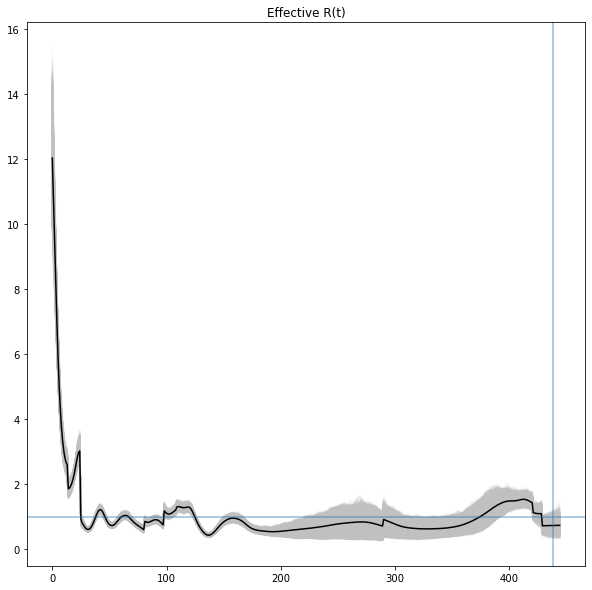

In [213]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(trace_11['r_t'].T, c='silver', alpha=0.1)
ax.plot(trace_11['r_t'].mean(0), c='black', alpha=1)
ax.axhline(y=1, alpha=0.5)
ax.axvline(x=end_date, alpha=0.5)
ax.set_title("Effective R(t)")
plt.show()
fig.savefig(rt_fp)

Accuracy Measures

In [214]:
prediction_summary = az.summary(trace_11, 'Obs_missing')

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [215]:
prediction_summary = prediction_summary[['mean','sd','hdi_3%','hdi_97%']]
prediction_summary.index = ['t+'+str(x) for x in range(1, prediction_t+1)]

In [216]:
prediction_summary['Actual'] = actual
prediction_summary = prediction_summary[['Actual']+['mean','sd','hdi_3%','hdi_97%']]
prediction_summary.columns = ['Actual','Predicted_Mean','sd','hdi_3%','hdi_97%']

In [217]:
prediction_summary

,Actual,Predicted_Mean,sd,hdi_3%,hdi_97%
t+1,21,31.124,5.899,21.0,42.0
t+2,24,31.280,6.386,20.0,43.0
t+3,15,30.887,6.405,19.0,42.0
t+4,15,31.105,6.419,18.0,42.0
t+5,23,30.450,6.337,18.0,41.0
t+6,19,30.123,6.789,17.0,43.0
t+7,16,29.149,7.160,16.0,42.0


In [218]:
prediction_summary.to_csv(results_fp)

Beta

In [219]:
b_coefs = az.summary(trace_11, ['b_'+str(x) for x in range(10)])
b_coefs.to_csv(beta_fp)

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


# Walk Forward CV Analysis

In [220]:
os.listdir('../Results')

['SM_Trace_Start_115_prediction_ahead_2_1500_3500',
 'SM_Trace_Start_115_prediction_ahead_2_1500_3500_analysis',
 'SM_Trace_Start_122_prediction_ahead_2_1500_3500',
 'SM_Trace_Start_122_prediction_ahead_2_1500_3500_analysis',
 'SM_Trace_Start_129_prediction_ahead_2_1500_3500',
 'SM_Trace_Start_129_prediction_ahead_2_1500_3500_analysis',
 'SM_Trace_Start_136_prediction_ahead_2_1500_3500',
 'SM_Trace_Start_136_prediction_ahead_2_1500_3500_analysis',
 'SM_Trace_Start_143_prediction_ahead_2_1500_3500',
 'SM_Trace_Start_143_prediction_ahead_2_1500_3500_analysis',
 'SM_Trace_Start_150_prediction_ahead_2_1500_3500',
 'SM_Trace_Start_150_prediction_ahead_2_1500_3500_analysis',
 'SM_Trace_Start_410_prediction_ahead_2_1500_4000',
 'SM_Trace_Start_410_prediction_ahead_2_1500_4000_analysis',
 'SM_Trace_Start_417_prediction_ahead_2_1500_3500',
 'SM_Trace_Start_417_prediction_ahead_2_1500_3500_analysis',
 'SM_Trace_Start_424_prediction_ahead_2_1500_3500',
 'SM_Trace_Start_424_prediction_ahead_2_1500

In [227]:
end_date_list = [410, 417, 424, 431, 438]
train_steps = 3500

for end_date in (end_date_list):
    plt_dir = f"../Results/SM_Trace_Start_{end_date}_prediction_ahead_{n_chains}_{tune_steps}_{train_steps}_analysis"

    energy_fp = os.path.join(plt_dir, 'energy.png')
    case_fp = os.path.join(plt_dir, 'counts_pred.png')
    latent_fp = os.path.join(plt_dir, 'latent_process.png')
    rt_fp = os.path.join(plt_dir, 'rt.png')
    results_fp = os.path.join(plt_dir, 'pred_results.csv')
    beta_fp = os.path.join(plt_dir, 'beta_results.csv')
    

In [228]:
date_events = data['Date'].iloc[start_id:]

In [229]:
date_events = [x.date() for x in list(date_events)]

In [230]:
import matplotlib.image as mpimg

## Energy Plots

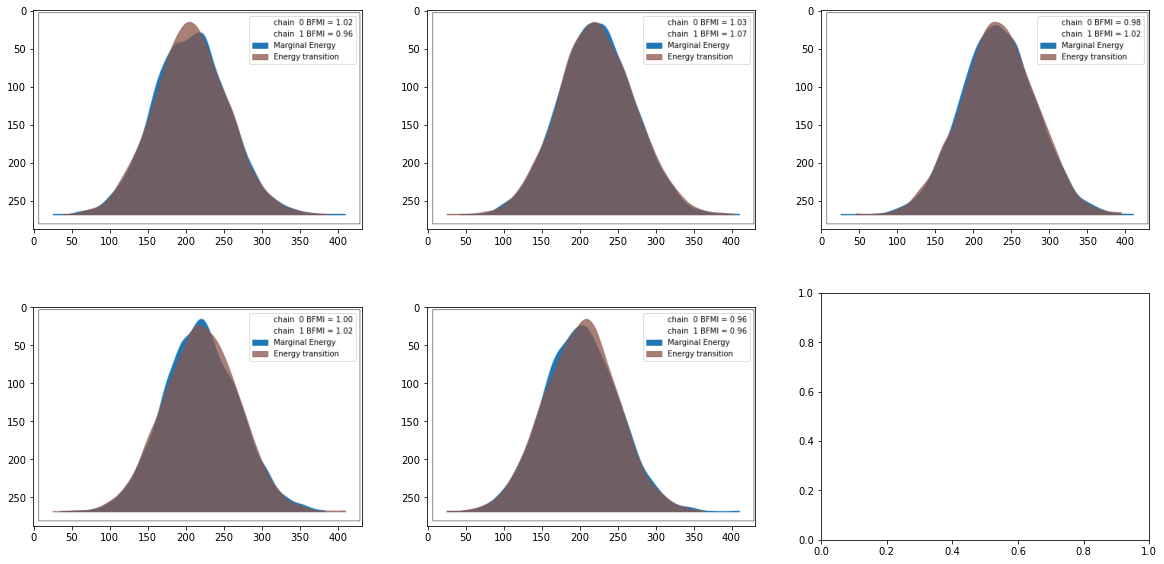

In [231]:
end_date_list = [410, 417, 424, 431, 438]

fig, ax = plt.subplots(2,3, figsize=(20,10))
ids = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2)]
for end_date, plt_n in zip(end_date_list, ids):
    plt_dir = f"../Results/SM_Trace_Start_{end_date}_prediction_ahead_{n_chains}_{tune_steps}_{train_steps}_analysis"
    energy_fp = os.path.join(plt_dir, 'energy.png')
    energy_img = mpimg.imread(energy_fp)
    ax[plt_n[0], plt_n[1]].imshow(energy_img)
    
    

## Pred Plots

In [232]:
from mpl_toolkits.axes_grid1 import ImageGrid

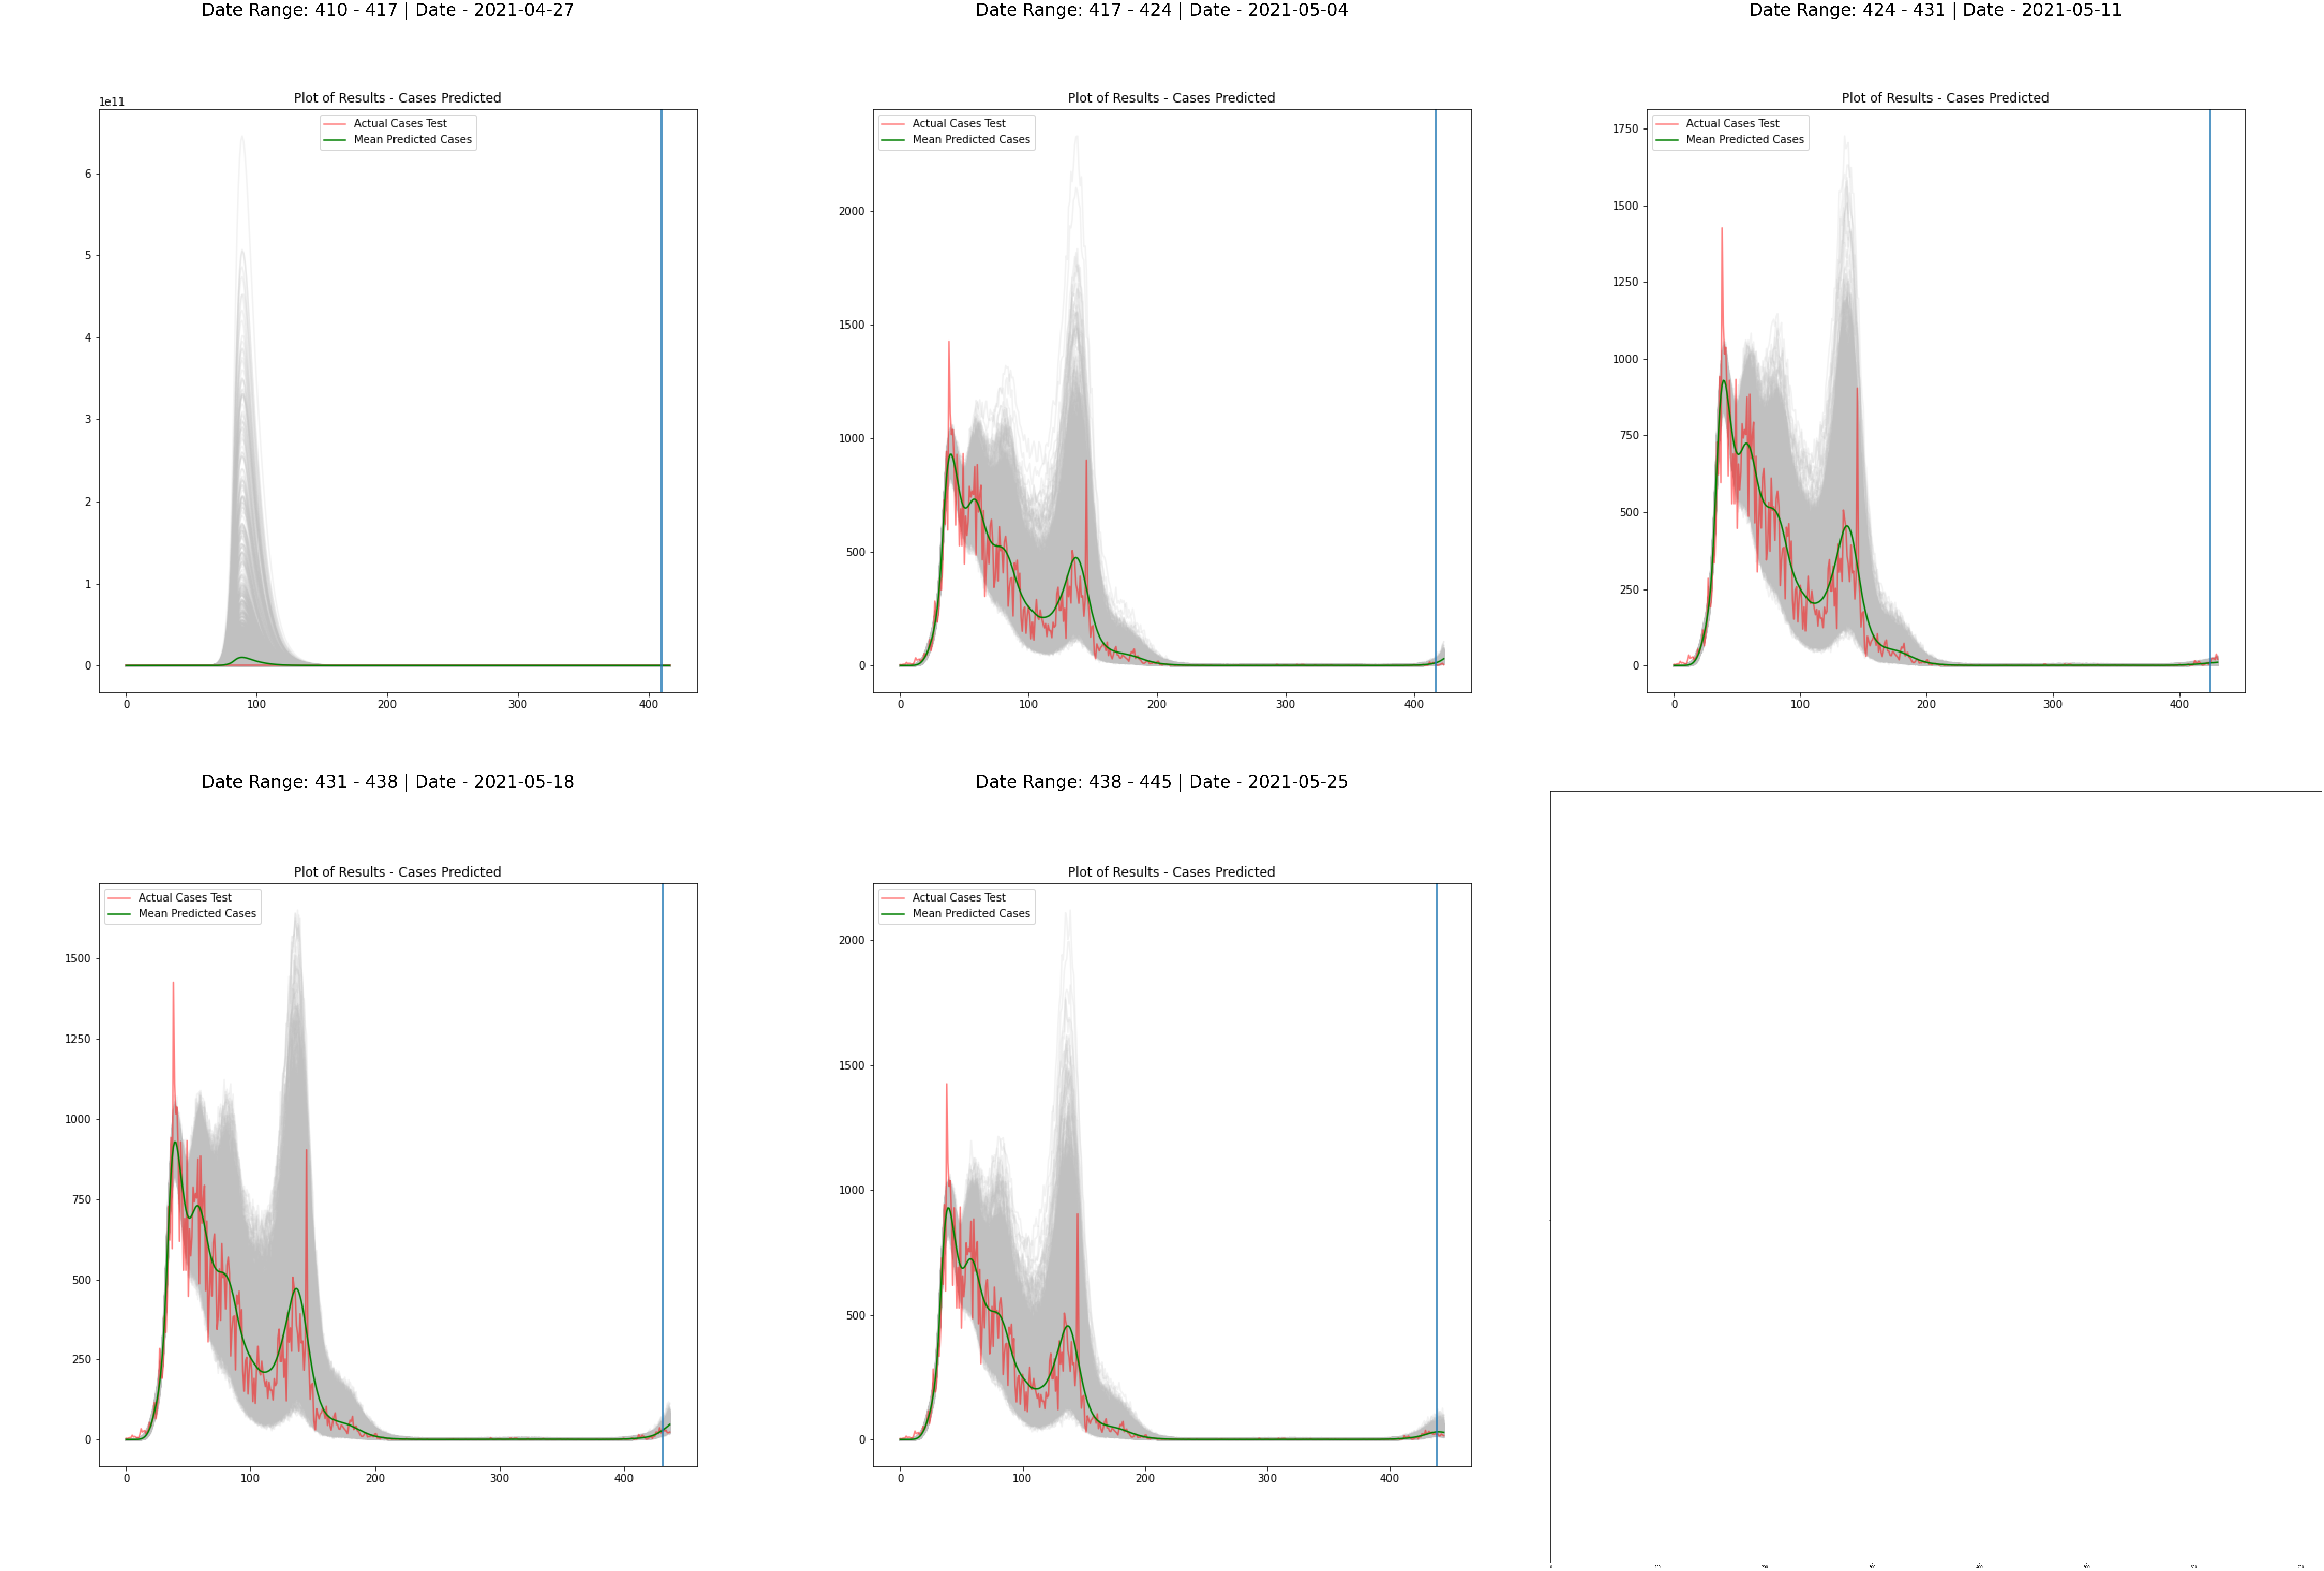

In [233]:
fig = plt.figure(figsize=(120., 120.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, end_date in zip(grid, end_date_list):
    
    start_date = date_events[end_date]
    
    plt_dir = f"../Results/SM_Trace_Start_{end_date}_prediction_ahead_{n_chains}_{tune_steps}_{train_steps}_analysis"
    case_fp = os.path.join(plt_dir, 'counts_pred.png')
    case_img = mpimg.imread(case_fp)
    # Iterating over the grid returns the Axes.
    ax.imshow(case_img)
    ax.set_title('Date Range: '+str(end_date)+' - '+str(end_date+prediction_t)+ ' | Date - '+str(start_date), fontsize=50)
    ax.axis('off')

## Latent Plots

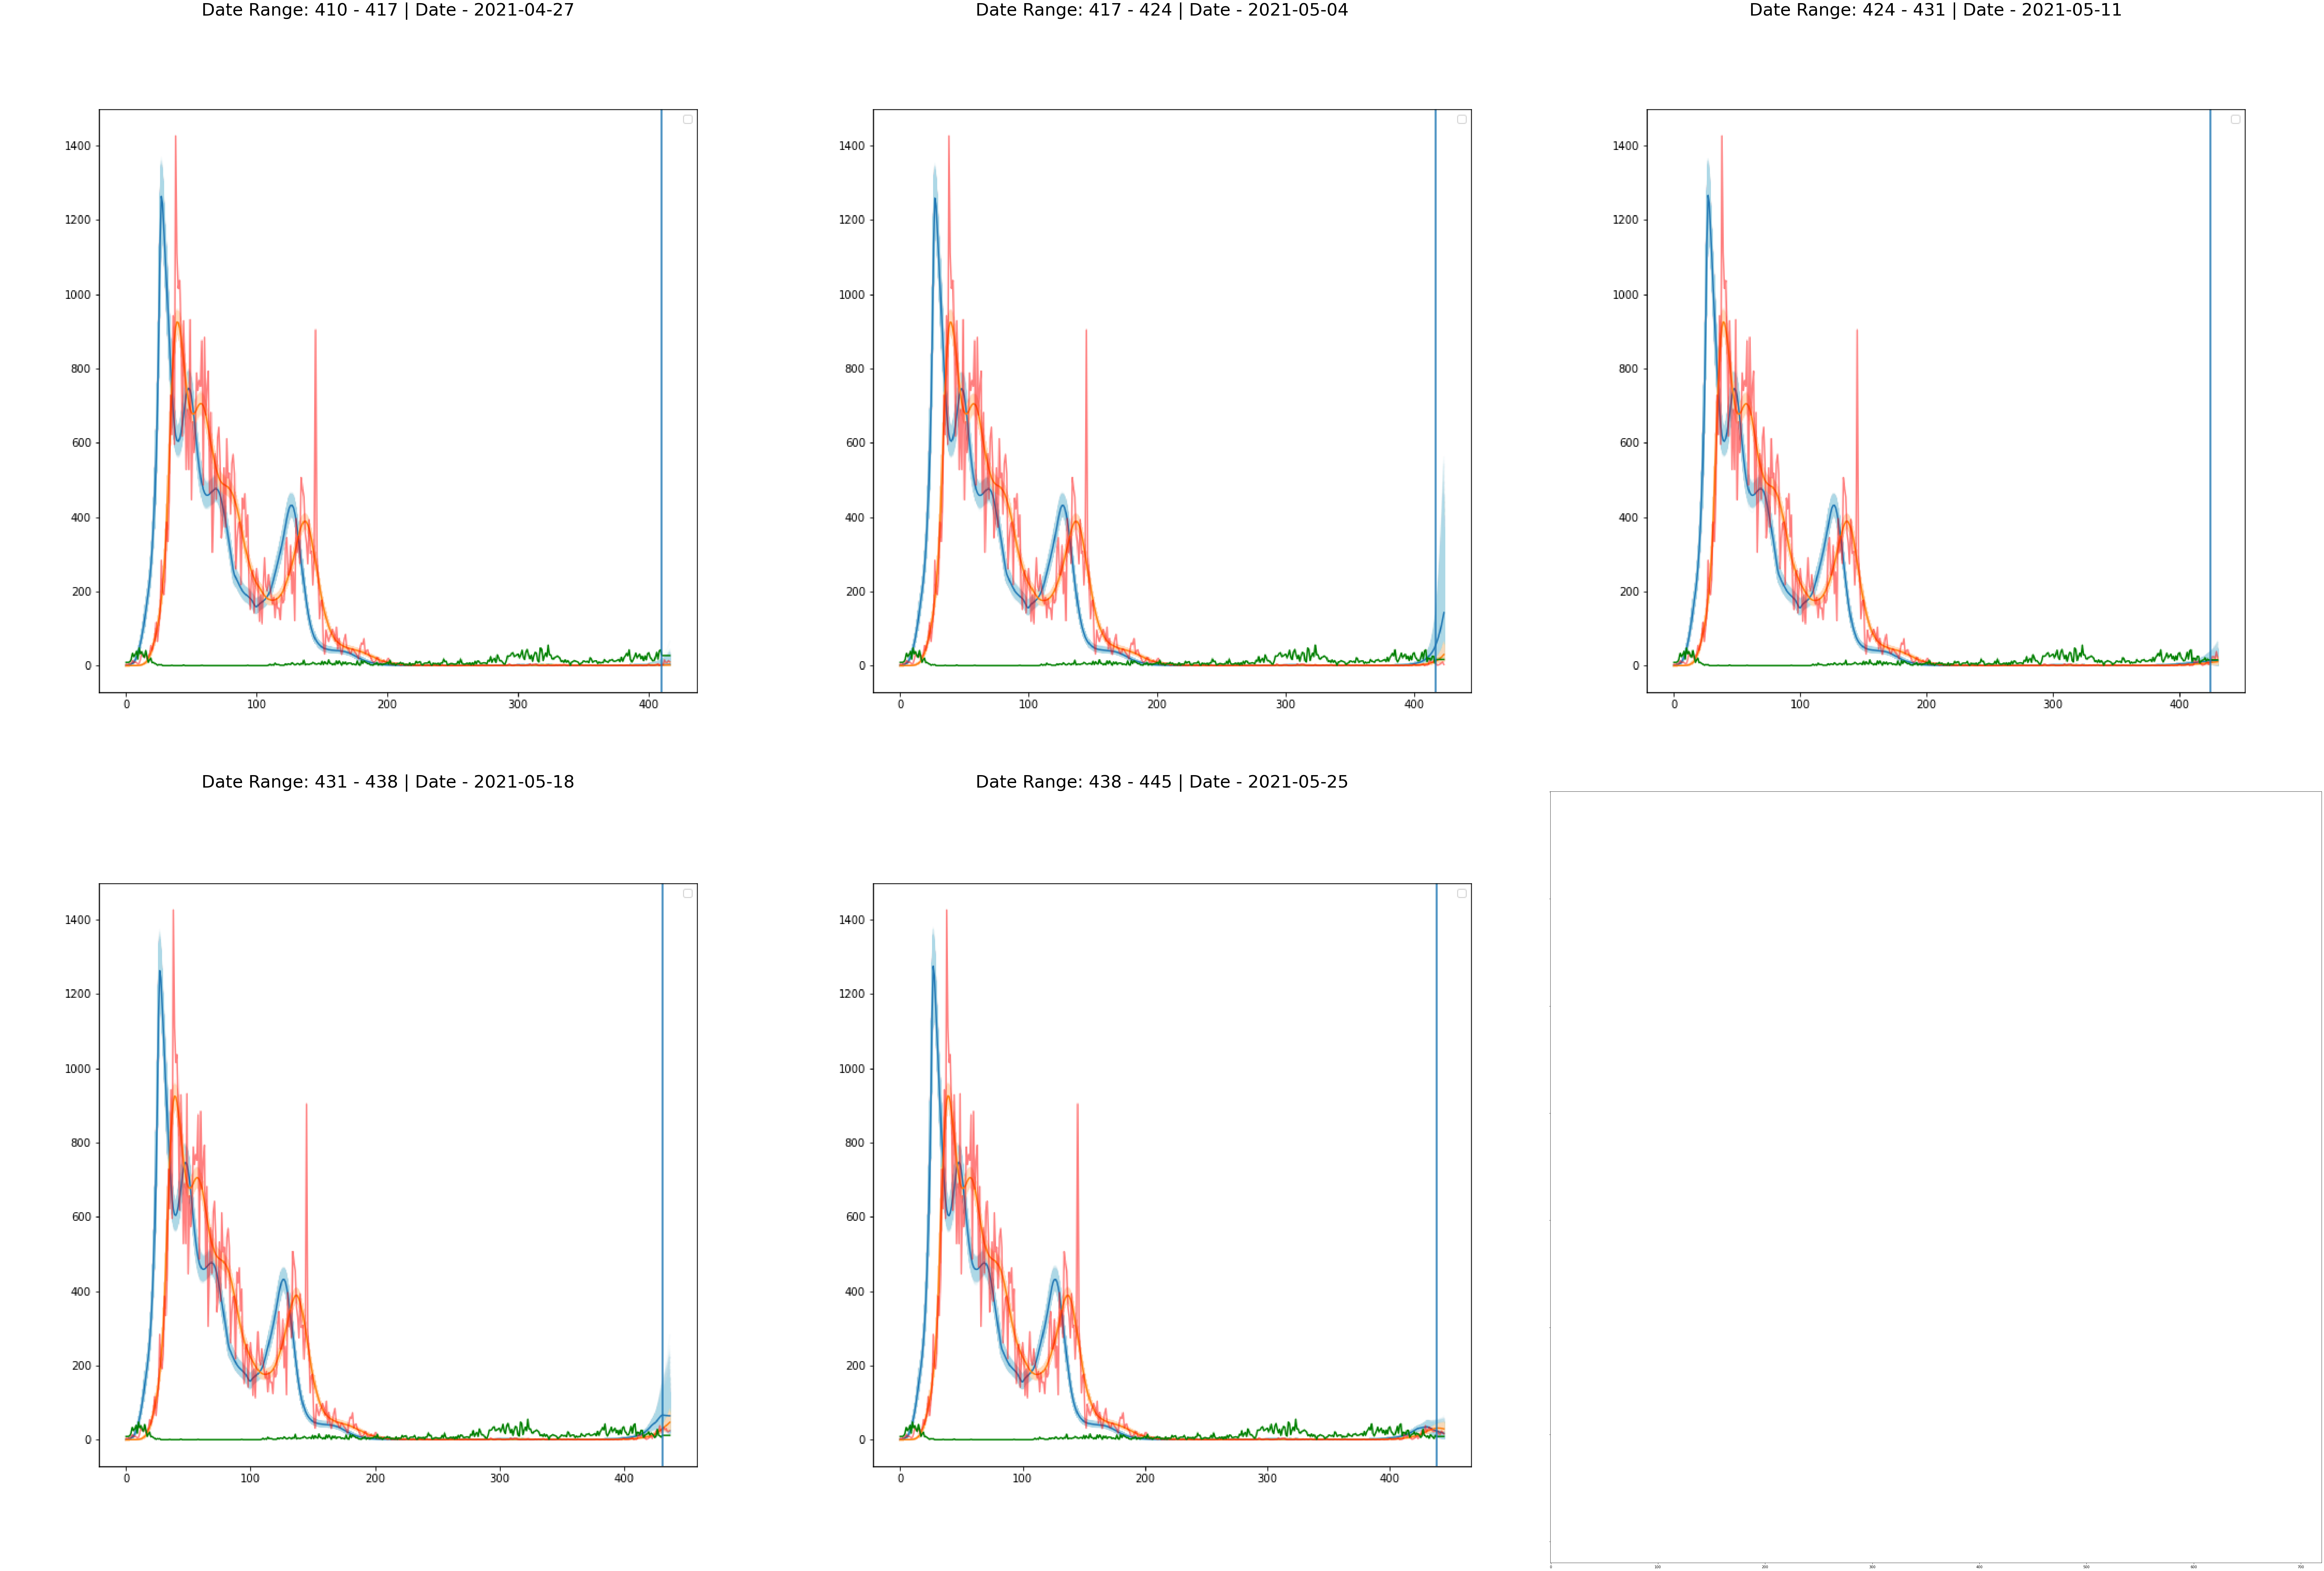

In [234]:
fig = plt.figure(figsize=(120., 120.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, end_date in zip(grid, end_date_list):
    
    start_date = date_events[end_date]
    
    plt_dir = f"../Results/SM_Trace_Start_{end_date}_prediction_ahead_{n_chains}_{tune_steps}_{train_steps}_analysis"
    latent_fp = os.path.join(plt_dir, 'latent_process.png')
    latent_img = mpimg.imread(latent_fp)
    # Iterating over the grid returns the Axes.
    ax.imshow(latent_img)
    ax.set_title('Date Range: '+str(end_date)+' - '+str(end_date+prediction_t)+ ' | Date - '+str(start_date), fontsize=50)
    ax.axis('off')

## R_t

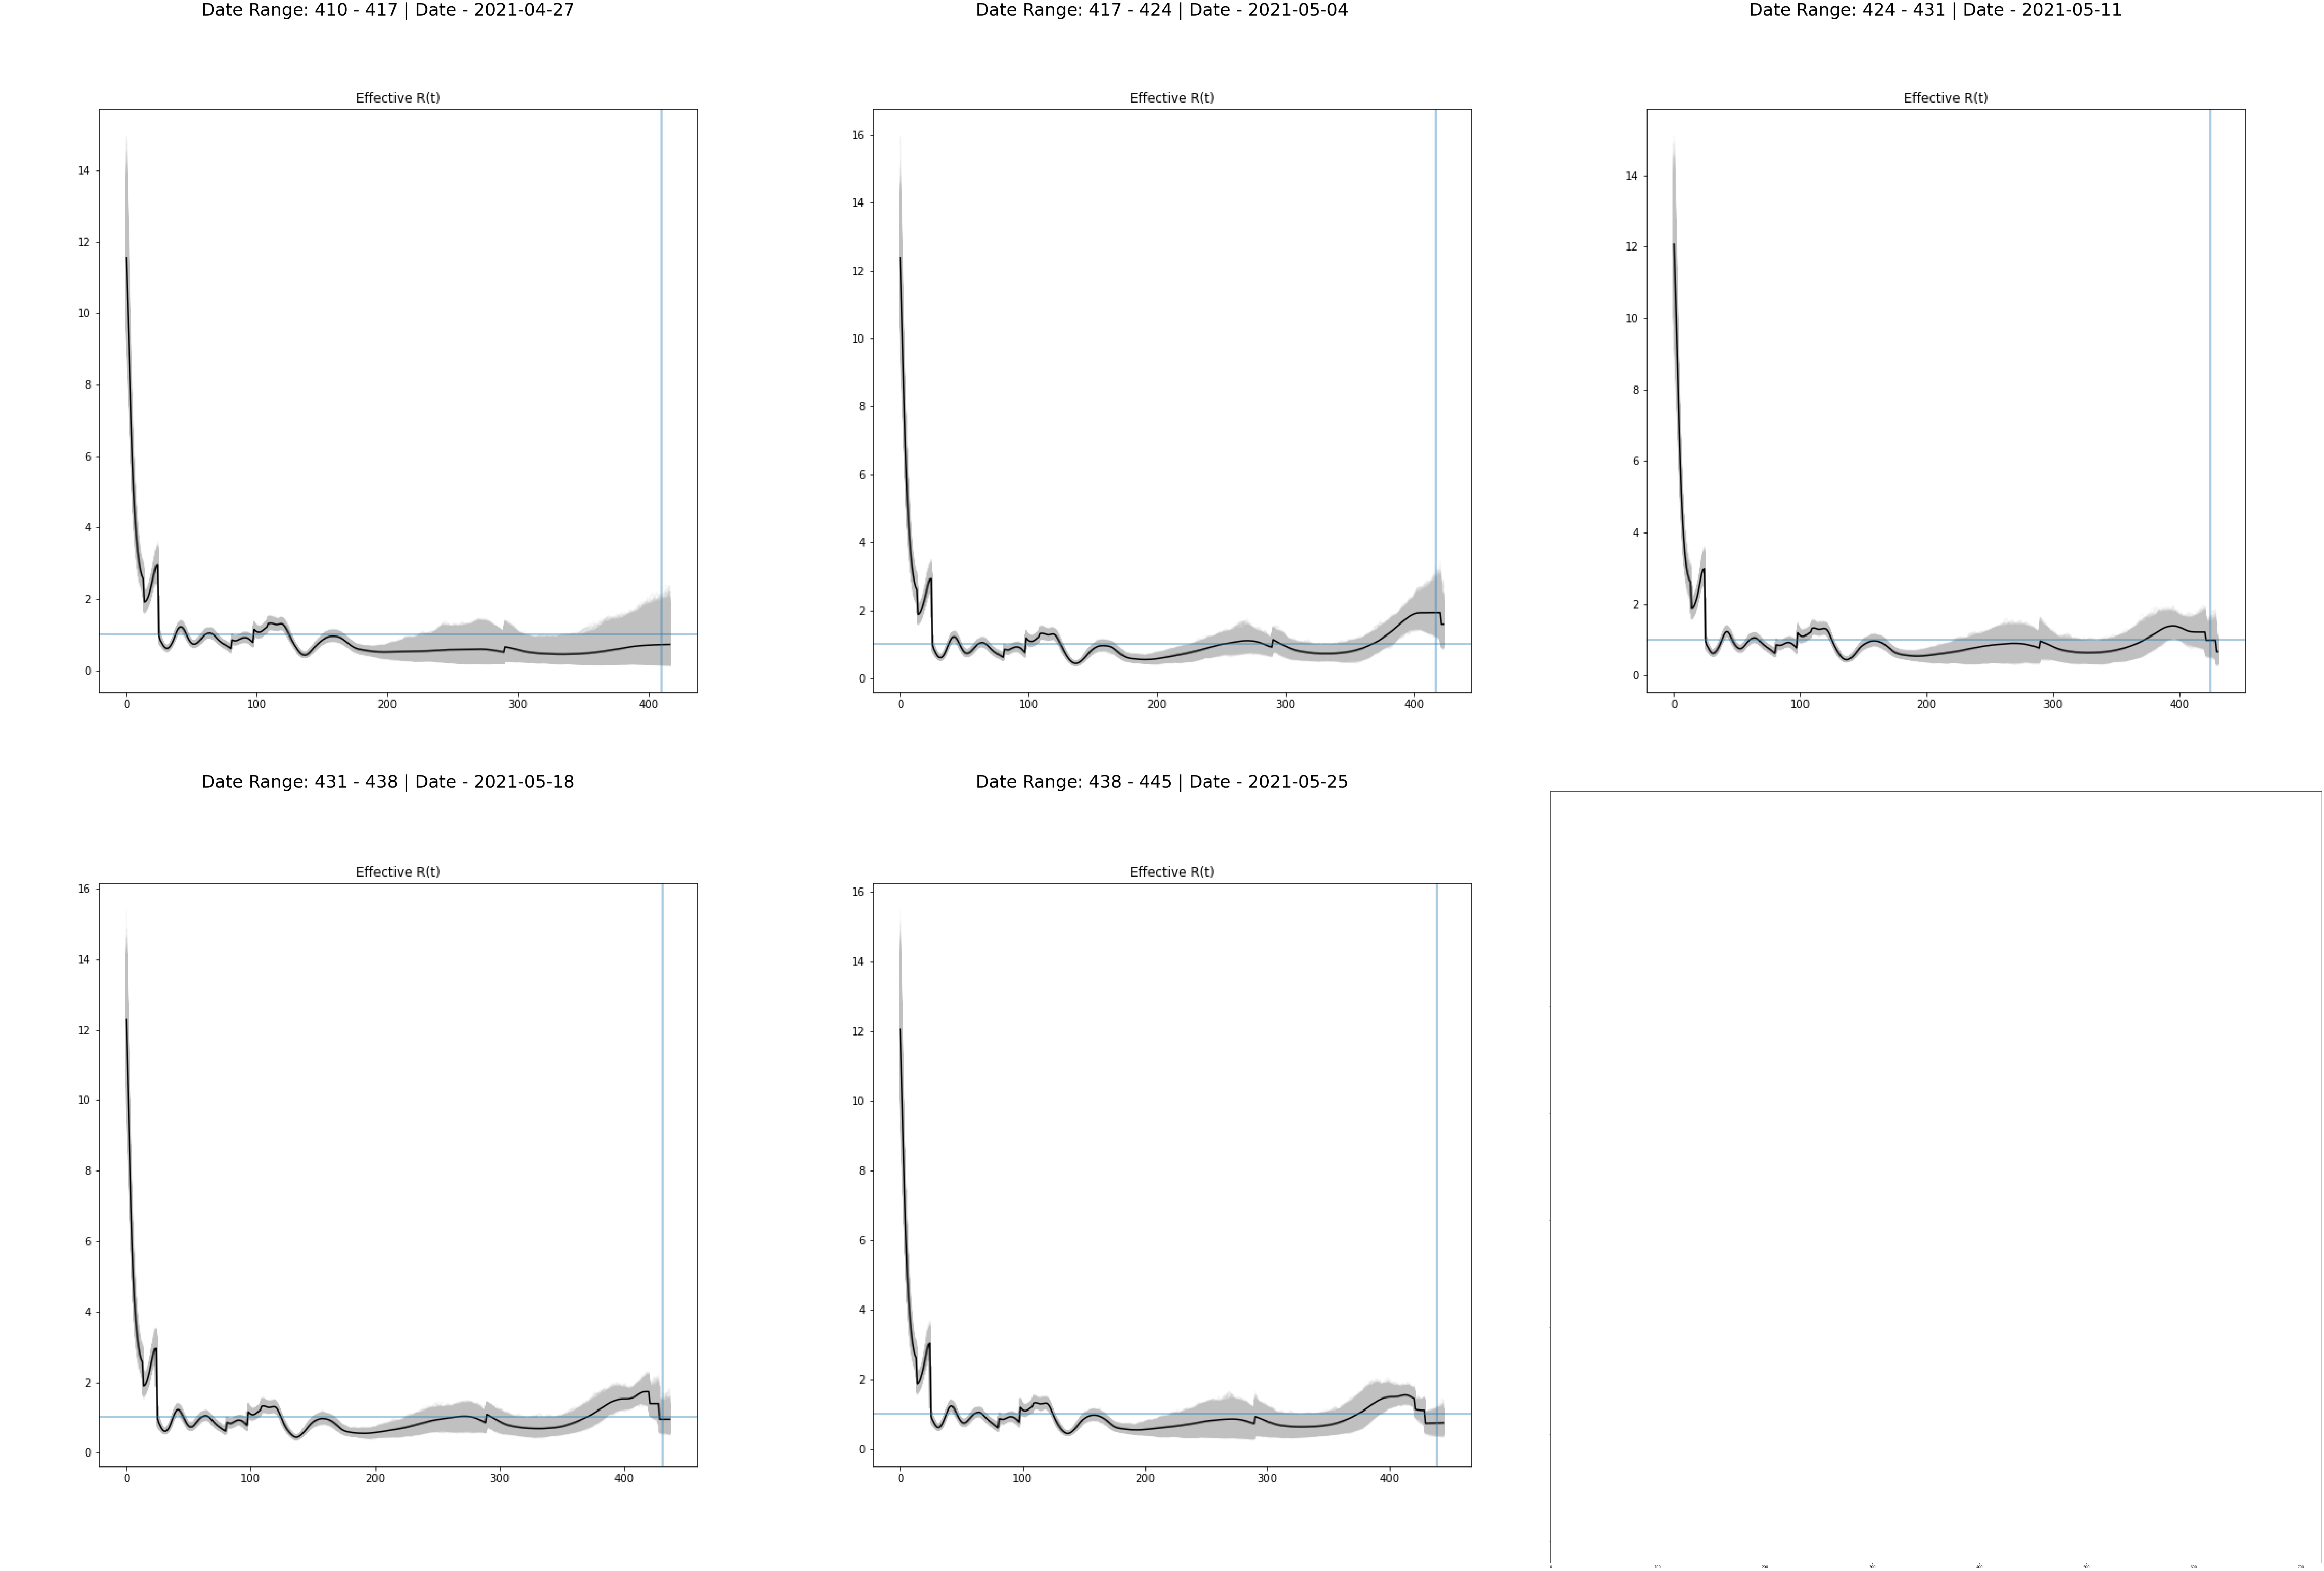

In [235]:
fig = plt.figure(figsize=(120., 120.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, end_date in zip(grid, end_date_list):
    
    start_date = date_events[end_date]
    
    plt_dir = f"../Results/SM_Trace_Start_{end_date}_prediction_ahead_{n_chains}_{tune_steps}_{train_steps}_analysis"
    rt_fp = os.path.join(plt_dir, 'rt.png')
    rt_img = mpimg.imread(rt_fp)
    # Iterating over the grid returns the Axes.
    ax.imshow(rt_img)
    ax.set_title('Date Range: '+str(end_date)+' - '+str(end_date+prediction_t)+ ' | Date - '+str(start_date), fontsize=50)
    ax.axis('off')

# Load Prediction numbers

In [241]:
end_date_list = [417, 424, 431, 438]
prediction_list = []
beta_list = []

fold_rmse_list = []
fold_steps_rmse_list = []

actual_list = []
for end_date in end_date_list:
    plt_dir = f"../Results/SM_Trace_Start_{end_date}_prediction_ahead_{n_chains}_{tune_steps}_{train_steps}_analysis"
    results_fp = os.path.join(plt_dir, 'pred_results.csv')
    beta_fp = os.path.join(plt_dir, 'beta_results.csv')
    
    preds_df = pd.read_csv(results_fp)
    beta_df = pd.read_csv(beta_fp)
    
    fold_rmse = np.mean(np.sqrt((preds_df['Actual'] - preds_df['Predicted_Mean'])**2))
    fold_rmse_list.append(fold_rmse)
    
    fold_steps_rmse = (np.sqrt((preds_df['Actual'] - preds_df['Predicted_Mean'])**2))
    fold_steps_rmse = pd.DataFrame(fold_steps_rmse).T
    fold_steps_rmse.columns = ['t+'+str(x) for x in range(1,prediction_t+1)]
    fold_steps_rmse_list.append(fold_steps_rmse)
    
    fold_actual = pd.DataFrame(preds_df['Actual']).T
    fold_actual.columns = ['t+'+str(x) for x in range(1,prediction_t+1)]
    actual_list.append(fold_actual)
    
    
    prediction_list.append(preds_df)
    beta_list.append(beta_df)

In [242]:
step_rmse_df = pd.concat(fold_steps_rmse_list)
step_rmse_df['Overall_RMSE'] = fold_rmse_list
step_rmse_df['Fold_Start'] = end_date_list

In [243]:
step_rmse_df

,t+1,t+2,t+3,t+4,t+5,t+6,t+7,Overall_RMSE,Fold_Start
0,7.627,13.384,14.656,15.225,15.188,15.078,27.133,15.470143,417
0,4.592,1.477,15.157,14.296,8.937,27.840,10.772,11.867286,424
0,2.589,2.230,7.960,7.458,18.874,21.800,22.965,11.982286,431
0,10.124,7.280,15.887,16.105,7.450,11.123,13.149,11.588286,438


In [244]:
pd.DataFrame(step_rmse_df.iloc[:,:-1].mean(0)).T

,t+1,t+2,t+3,t+4,t+5,t+6,t+7,Overall_RMSE
0,6.233,6.09275,13.415,13.271,12.61225,18.96025,18.50475,12.727


In [245]:
actuals = pd.concat(actual_list)
actuals.reset_index(drop=True, inplace=True)
actuals['Mean'] = actuals.mean(1)
actuals

,t+1,t+2,t+3,t+4,t+5,t+6,t+7,Mean
0,5,1,2,4,7,10,3,4.571429
1,13,10,24,24,19,38,21,21.285714
2,27,34,27,30,22,22,24,26.571429
3,21,24,15,15,23,19,16,19.000000


Error in PCT

In [246]:
pct_step_errors = pd.DataFrame(step_rmse_df.iloc[:,:-1].values / actuals.values)
pct_step_errors.columns = actuals.columns
pct_step_errors

,t+1,t+2,t+3,t+4,t+5,t+6,t+7,Mean
0,1.525400,13.384000,7.328000,3.806250,2.169714,1.507800,9.044333,3.384094
1,0.353231,0.147700,0.631542,0.595667,0.470368,0.732632,0.512952,0.557523
2,0.095889,0.065588,0.294815,0.248600,0.857909,0.990909,0.956875,0.450946
3,0.482095,0.303333,1.059133,1.073667,0.323913,0.585421,0.821813,0.609910


In [247]:
pd.DataFrame(pct_step_errors.mean(0)).T

,t+1,t+2,t+3,t+4,t+5,t+6,t+7,Mean
0,0.614154,3.475155,2.328372,1.431046,0.955476,0.95419,2.833993,1.250618


## Betas

In [248]:
beta_list[0]

,Unnamed: 0,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,b_0,-0.008,0.030,-0.062,0.050,0.003,0.002,86.0,351.0,1.03
1,b_1,-0.009,0.029,-0.060,0.046,0.001,0.001,869.0,2048.0,1.00
2,b_2,0.010,0.030,-0.044,0.067,0.003,0.002,90.0,223.0,1.02
3,b_3,-0.016,0.029,-0.069,0.040,0.001,0.001,525.0,1312.0,1.01
4,b_4,-0.065,0.029,-0.119,-0.012,0.002,0.002,183.0,910.0,1.03
5,b_5,0.066,0.012,0.044,0.088,0.006,0.005,4.0,16.0,1.42
6,b_6,-0.022,0.003,-0.029,-0.016,0.002,0.001,4.0,25.0,1.44
7,b_7,-0.001,0.029,-0.055,0.053,0.002,0.001,301.0,1128.0,1.01
8,b_8,0.011,0.030,-0.047,0.064,0.001,0.001,1049.0,2028.0,1.01
9,b_9,-0.006,0.030,-0.065,0.048,0.002,0.001,382.0,1774.0,1.01


In [249]:
beta_list[0].loc[i,['mean','hdi_3%', 'hdi_97%']]

mean      -0.006
hdi_3%    -0.065
hdi_97%    0.048
Name: 9, dtype: object

In [250]:
# Plot betas and HDI across the folds
time_means = []
time_3 = []
time_97 = []
for i in range(10):
    b_means = []
    b_3 = []
    b_97 = []
    for beta_df in beta_list:
        output = beta_df.loc[i,['mean','hdi_3%', 'hdi_97%']].values
        
        b_means.append(output[0])
        b_3.append(output[1])
        b_97.append(output[2])
        
    time_means.append(b_means)
    time_3.append(b_3)
    time_97.append(b_97)

In [251]:
ax_list = [(x,y) for x in range(2) for y in range(5)]

In [252]:
NPIS_wanted.columns

Index(['Date', 'Compulsory_Mask', 'Eat_In_Ban', 'Entry_Recording', 'Lockdown',
       'Sch_Closure', 'Gathering_Max', 'Mall_Distancing', 'Recreation',
       'Workplace_Closure', 'Worship'],
      dtype='object')

ValueError: 'x' and 'y' must have the same size

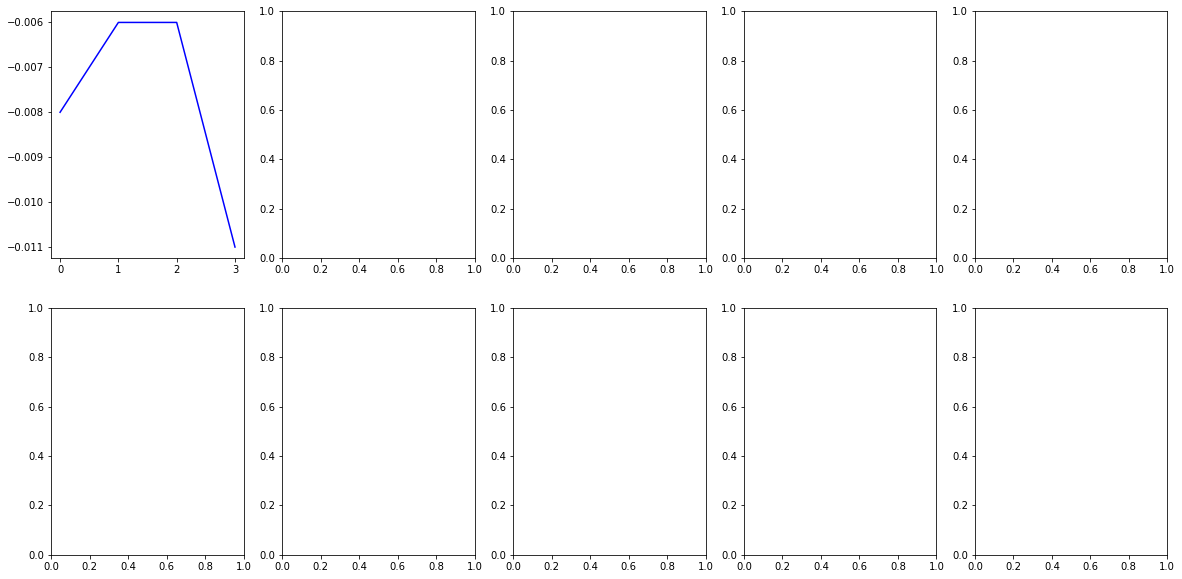

In [253]:

fig, ax = plt.subplots(2,5,figsize=(20,10))
ax_list = [(x,y) for x in range(2) for y in range(5)]

for i in range(10):
    ax_x = ax_list[i][0]
    ax_y = ax_list[i][1]
    
    mean_val = time_means[i]
    lower_3 = time_3[i]
    upper_3 = time_97[i]

    lower_err = np.array(mean_val) - np.array(lower_3)
    upper_err = np.array(upper_3) - np.array(mean_val)
    ax[ax_x, ax_y].plot(time_means[0], c='b')
    ax[ax_x, ax_y].errorbar(list(range(6)),time_means[0], yerr=[lower_err,upper_err])
    ax[ax_x, ax_y].set_ylim([-0.1,0.1])
    
    ax[ax_x, ax_y].set_title(NPIS_wanted.columns[i])

In [354]:
NPIS_wanted

,Compulsory_Mask,Eat_In_Ban,Entry_Recording,Lockdown,Sch_Closure,Gathering_Max,Mall_Distancing,Recreation,Workplace_Closure,Worship
50,0,0,0,0,0,150.0,1.15,1.00,1.0,1.00
51,0,0,0,0,0,150.0,1.15,1.00,1.0,1.00
52,0,0,0,0,0,150.0,1.15,1.00,1.0,1.00
53,0,0,0,0,0,150.0,1.15,1.00,1.0,1.00
54,0,0,0,0,0,150.0,1.15,1.00,1.0,1.00
...,...,...,...,...,...,...,...,...,...,...
493,1,1,1,0,0,2.0,16.00,0.25,0.5,0.25
494,1,1,1,0,0,2.0,16.00,0.25,0.5,0.25
495,1,1,1,0,0,2.0,16.00,0.25,0.5,0.25
496,1,1,1,0,0,2.0,16.00,0.25,0.5,0.25


## Analyse split data

In [32]:
from sm_model import SemiMechanisticModels 
from sm_data import generate_prediction_data, generate_NPI_prediction_data, generate_ground_truth_forecast
import os

In [44]:
save_fp = f"../Results/SM_V2_Trace_Start_136_prediction_ahead_2_1500_3500_id_af24cb6904bb4dc2847f63dddb528b82"

In [45]:
start_id = 50
end_date = 136
prediction_t = 7
val_run=True

In [46]:
# IMPORT DATA
DATA_PATH = os.path.join('../covid19-modelling-sg/data/statistics', 'epidemic_curve.csv')
NPI_PATH = 'data/lockdown_index.csv'


community_input, dorm_input, imported_input, total_input, len_observed = generate_prediction_data(DATA_PATH, start_id=start_id,
                            end_date=end_date, prediction_t=prediction_t, imported_case_extra='ma',
                            separate_dorms=True)


if val_run:
    com_gt, dorm_gt, import_gt, total_gt = generate_ground_truth_forecast(DATA_PATH, start_id=start_id,
                        end_date=end_date, prediction_t=prediction_t)


NPIS_array, date_ver = generate_NPI_prediction_data(NPI_PATH, start_id=start_id, end_date=end_date, prediction_t=7)

num_NPIS = NPIS_array.shape[1]


# TRAIN MODEL
sm_forecast = SemiMechanisticModels()
# Instatiate model based on data
sm_forecast.build_model(local_cases=community_input,
                        dorm_cases=dorm_input,
                        imported_cases=imported_input,
                        NPIS_array=NPIS_array,
                        len_observed=len_observed,
                        total_cases=None,
                        separate_dorms=True,
                        likelihood_fun='PO')

imported cases ma
Length Community training cases:  136
Length Dorm training cases:  136
Length into model:  143   143   143
hi


/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/model.py:1754: ImputationWarning: Data in Obs_local contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/model.py:1754: ImputationWarning: Data in Obs_dorm contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [47]:
import pymc3 as pm
with sm_forecast.model:
    trace = pm.load_trace(save_fp)

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:>

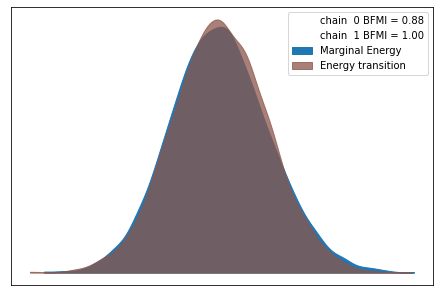

In [48]:
import arviz as az 
az.plot_energy(trace)

In [49]:
beta_summary = az.summary(trace, 'b_index')

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [50]:
beta_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_index,-0.048,0.03,-0.104,0.007,0.001,0.001,1247.0,2464.0,1.0


/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'b_index'}>,
        <AxesSubplot:title={'center':'b_index'}>]], dtype=object)

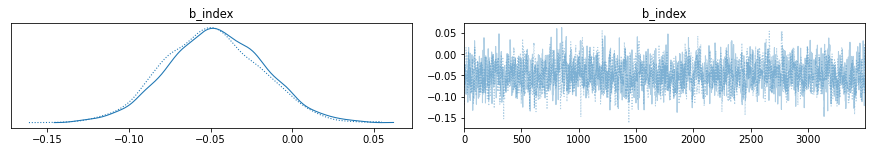

In [51]:
az.plot_trace(trace, 'b_index')

In [52]:
eps_summary = az.summary(trace, 'eps_t')

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [53]:
eps_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
eps_t,0.001,0.001,0.0,0.003,0.0,0.0,10709.0,3759.0,1.0


/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'eps_t'}>,
        <AxesSubplot:title={'center':'eps_t'}>]], dtype=object)

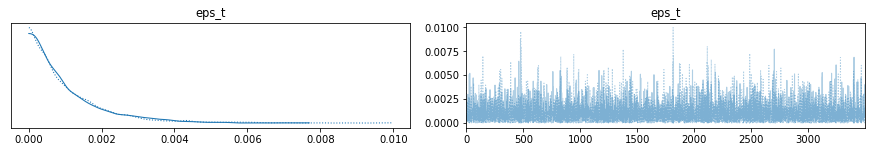

In [54]:
az.plot_trace(trace, 'eps_t')